In [1]:
#!python -m pip install torch
import torch
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
#!python -m pip install tensorflow
import auto_encoder
import math
import bisect
#!python -m pip install pickle
import pickle
import copy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed(num_samples):
    pts = []
    i = 0
    it1 = int(math.sqrt(num_samples)/10)
    it2 = int((num_samples/10) - math.sqrt(num_samples))
    for j in range (10):
        for k in range(10):
            pts.append(i)
            i+=it1
        i+=it2
    return pts

In [3]:
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 

In [4]:
def error_points(predicted, truth, num):
    diffs = abs((predicted) - (truth))/(truth)
    points = (-np.asarray(diffs)).argsort()[:num]
    return points

In [5]:
def error_data(mag, mag_t):
    return abs((mag+1) - (mag_t+1))/(mag_t+1)

In [6]:
def print_points(data1, qubits, error_points):    
    data = np.load(data1)
    Bx = data['fields'].T[qubits]
    Bz = data['fields'].T[2*qubits]
    points = []
    for i in error_points:
        points.append((Bx[i],Bz[i]))
    print(points)

In [7]:
def expand_pool(old_pool, error_points, max_pool_size):
    for i in error_points:
        num = int(i)
        if(i not in old_pool):
            bisect.insort(old_pool,i)
        else:
            Bz_low_num = num-1
            Bz_high_num= num+1
            Bz_low_flag=True
            Bz_high_flag=True
            
            Bx_low_num = int(num-math.sqrt(max_pool_size))
            Bx_high_num= int(num+math.sqrt(max_pool_size))
            Bx_low_flag=True
            Bx_high_flag=True
            
            while(Bz_low_flag or Bz_high_flag or Bx_low_flag or Bx_high_flag):
                if(Bz_low_flag):
                    if(Bz_low_num<=0 or Bz_low_num % math.sqrt(max_pool_size)==math.sqrt(max_pool_size)-1):
                        Bz_low_flag=False
                    elif(Bz_low_num not in old_pool):
                        bisect.insort(old_pool,Bz_low_num)
                        Bz_low_flag=False
                    else:
                        Bz_low_num-=1
                if(Bz_high_flag):
                    if(Bz_high_num>=max_pool_size or Bz_high_num % math.sqrt(max_pool_size)==0):
                        Bz_high_flag=False
                    elif(Bz_high_num not in old_pool):
                        bisect.insort(old_pool, Bz_high_num)
                        Bz_high_flag=False
                    else:
                        Bz_high_num+=1
                if(Bx_low_flag):
                    if(Bx_low_num<=0):
                        Bx_low_flag=False
                    elif(Bx_low_num not in old_pool):
                        bisect.insort(old_pool, Bx_low_num)
                        Bx_low_flag=False
                    else:
                        Bx_low_num-=int(math.sqrt(max_pool_size))
                if(Bx_high_flag):
                    if(Bx_high_num>=max_pool_size or Bx_high_num % math.sqrt(max_pool_size)==0):
                        Bx_high_flag=False
                    elif(Bx_high_num not in old_pool):
                        bisect.insort(old_pool, Bx_high_num)
                        Bx_high_flag=False
                    else:
                        Bx_high_num+=int(math.sqrt(max_pool_size))    
                    
    return old_pool

In [8]:
get_dataset = auto_encoder.get_dataset
data_2 = '2-qubits.bin'
data_4 = '4-qubits.bin'
data_6 = '6-qubits.bin'
data_7 = '7-qubits.bin'
# data_8 = '8_qubit_crit_data.npz'
# data_9 = '9_qubit_crit_data.npz'

training_n_sizes = [2,4,7]
validation_n_sizes = [6,8,9]

pool_size = 2500

pts = seed(pool_size)

stop = 1

error_p = []

magnetization_6 = []
wave_func_6 = []

In [9]:
for learning_set in range (stop):

    training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
    training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
    training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 


    split1 = int(len(pts)*0.9)
    split2 = int(len(pts)/10)
    split1 += len(pts)-(split1+split2)
    
    training_data_2, val_data_2 = random_split(training_data_2, [split1,split2])
    training_data_4, val_data_4 = random_split(training_data_4, [split1,split2])
    training_data_7, val_data_7 = random_split(training_data_7, [split1,split2])

    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

    val_data_6 = get_dataset(data_6, 6, pool_size)
#     val_data_8 = get_dataset(data_8, 8, pool_size)
#     val_data_9 = get_dataset(data_9, 9, pool_size)

    val_datasets = [val_data_6, val_data_2, val_data_4, val_data_7] # val_data_8, val_data_9

    val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

    warmup_2 = next(iter(training_loaders[0]))
    warmup_4 = next(iter(training_loaders[1]))
    warmup_7 = next(iter(training_loaders[2]))

    mps_size = 5
    model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.MSELoss(reduction='sum')

    warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

    print("WARMUP TRAINING ITERATION: ", learning_set)
    for j in range(10):
        for i in range(3):
            for epoch in range(10):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 10 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    print("__________________________________________________")
    print()

    
    print("TRAINING ITERATION: ", learning_set)
    for j in range(10):
        print("Cycle: \t", j)
        print("*"*40)
        for i in range(3):
            for epoch in range(201):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 100 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    print("__________________________________________________")
    print()
    
    
    print("Training Validation ", learning_set)
    train_sizes, train_loader = enumerate(training_loaders)
    val_6 = next(iter(val_loaders[0]))
    #val_8 = next(iter(val_loaders[1]))
    #val_9 = next(iter(val_loaders[2]))
    val_2 = next(iter(val_loaders[1]))
    val_4 = next(iter(val_loaders[2]))
    val_7 = next(iter(val_loaders[3]))
    
    val_data = [(val_6,6),(val_2,2),(val_4,4),(val_7,7)]
    val_loaders, val_sizes = val_data
    
    auto_encoder.mps_fit(mps_size, train_loaders, train_sizes, val_loaders, val_sizes)
    
    

OSError: Failed to interpret file '2-qubits.bin' as a pickle

In [16]:
warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]



print("TRAINING LOSS ITERATION: ", learning_set)
for j in range (10):
    for i in range(3):
        if(not converged[i]):
            for epoch in range(10):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 10 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

      
print("__________________________________________________")
print()

warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
f = open("warmup_data_2.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

f = open("warmup_data_1.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

val_6 = next(iter(val_loaders[0]))
#val_8 = next(iter(val_loaders[1]))
#val_9 = next(iter(val_loaders[2]))
val_2 = next(iter(val_loaders[1]))
val_4 = next(iter(val_loaders[2]))
val_7 = next(iter(val_loaders[3]))

print("VALIDATION LOSS ITERATION: ", learning_set)
val_data = [(val_6,6),(val_2,2),(val_4,4),(val_7,7)]
#val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
loss_func = nn.MSELoss()
count=0
for data, size in val_data:
    with torch.no_grad():
        fields, wf = data
        gs = model(fields, size)
        loss = loss_func(gs,wf)
        current = loss.item() * (2**size)
        print(size,"\t" ,current)
        final_validation_loss[learning_set][count] = current
    count+=1

print("__________________________________________________")
print()

f = open("test_data_1.p", 'wb')
pickle.dump(val_data, f)

device = torch.device("cpu")
for N, train_loader in enumerate(training_loaders):            
    temp = 0
    sys_size = training_n_sizes[N]
    for i, (fields,wf) in enumerate(train_loader):
        fields = fields.to(device)
        gs = model(fields, sys_size)            
        loss = loss_func(gs, wf.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp += loss.item()
    temp = temp / (len(train_loader)) 

data_sizes = [2,4,6,7]#,8,9]
training_data_2 = get_dataset(data_2, 2, pool_size)
training_data_4 = get_dataset(data_4,4,pool_size)
training_data_7 = get_dataset(data_7,7,pool_size) 
val_data_6 = get_dataset(data_6, 6, pool_size)
#val_data_8 = get_dataset(data_8, 8, pool_size)
#val_data_9 = get_dataset(data_9, 9, pool_size)
mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7]#, val_data_8, val_data_9]
mag_loaders = [DataLoader(x, batch_size = len(val_data_6), num_workers=20) for x in mag_dat]

model.eval()
with torch.no_grad():
    n_systems = {}
    for j,loader in enumerate((mag_loaders)):
        sys_size = data_sizes[j]
        wave_functions = []
        true_wave = []
        for i, (fields,wf) in enumerate(loader):
            fields = fields
            gs = model(fields, sys_size)

            wave_functions.append(gs)
            true_wave.append(wf)

        n_systems[sys_size] = (wave_functions,true_wave)


#     data_y_2 = n_systems[2][0][0].numpy()
#     data_y_4 = n_systems[4][0][0].numpy()
#     data_y_7 = n_systems[7][0][0].numpy()
data_y_6 = n_systems[6][0][0].numpy()
#     data_y_8 = n_systems[8][0][0].numpy()
#     data_y_9 = n_systems[9][0][0].numpy()


#     print(data_y_2.shape)
#     data_y_2_t = n_systems[2][1][0].numpy()
#     data_y_4_t = n_systems[4][1][0].numpy()
#     data_y_7_t = n_systems[7][1][0].numpy()
data_y_6_t = n_systems[6][1][0].numpy()
#     data_y_8_t = n_systems[8][1][0].numpy()
#     data_y_9_t = n_systems[9][1][0].numpy()

#     vec = seq_to_magnetization(seq_gen(2),2)
#     vec_2 = (vec.view()).reshape((4,1))
#     mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
#     mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

#     vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
#     mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
#     mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))

vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

magnetization_6.append(mag_6)

#     vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
#     mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
#     mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

#     vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
#     mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
#     mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

#     vec_9 = seq_to_magnetization(seq_gen(9),9).reshape((512,1))
#     mag_9 = np.squeeze((np.power(data_y_9,2) @ vec_9))
#     mag_9_t = np.squeeze((np.power(data_y_9_t,2) @ vec_9))

error_pts = error_points(data_y_6, data_y_6_t, 10)
print("ERROR POINTS:")
print_points(data_6, 6, error_pts)

error_p.append(error_data(data_y_6,data_y_6_t))

pts = expand_pool(pts, error_pts, pool_size)
print("NEW SET: ")
print(pts)
print()
print("_________________________________")

TRAINING LOSS ITERATION:  0
2 	 0.0024403519928455353
4 	 0.0033827587030828
7 	 0.04768058657646179
2 	 0.002258509397506714
4 	 0.004823268391191959
7 	 0.04935653507709503
2 	 0.0019470334518700838
7 	 0.039856452494859695
2 	 0.0013789518270641565
7 	 0.027227871119976044
2 	 0.0012946446659043431
7 	 0.022766955196857452
2 	 0.0011837121564894915
7 	 0.022192830219864845
2 	 0.0010954298777505755
7 	 0.021468626335263252
2 	 0.0010349832009524107
7 	 0.020602300763130188
2 	 0.0009828751208260655
7 	 0.020057959482073784
2 	 0.0009233261225745082
7 	 0.019508007913827896
2 	 0.0008775846799835563
7 	 0.01877898909151554
2 	 0.0008373594610020518
7 	 0.018056856468319893
2 	 0.0007986766286194324
7 	 0.01732061058282852
2 	 0.0007594624767079949
7 	 0.016657888889312744
2 	 0.0007228058530017734
7 	 0.016047386452555656
2 	 0.0006865583709441125
7 	 0.015371917746961117
2 	 0.0006545317592099309
7 	 0.014651447534561157
2 	 0.0006219153292477131
7 	 0.0140533447265625
2 	 0.0005913

KeyboardInterrupt: 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


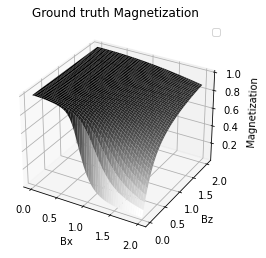

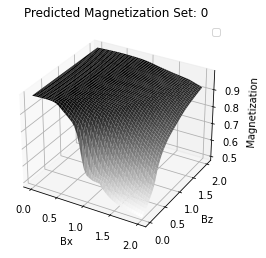

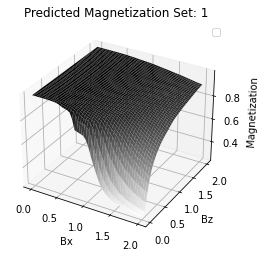

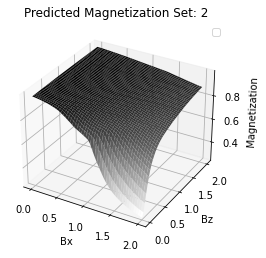

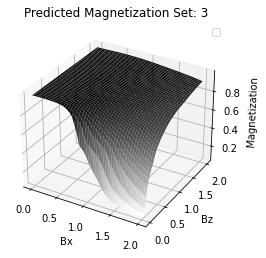

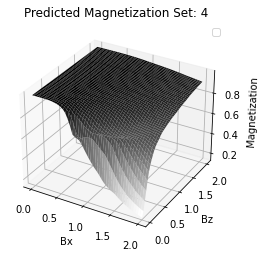

In [11]:
data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

x = np.reshape(Bx, (50, 50))
y = np.reshape(Bz, (50, 50))
z = np.reshape(mag_6_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

for i in range (stop):
    z = np.reshape(magnetization_6[i], (50, 50))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bx")
    ax.set_ylabel("Bz")
    ax.set_zlabel("Magnetization")

    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


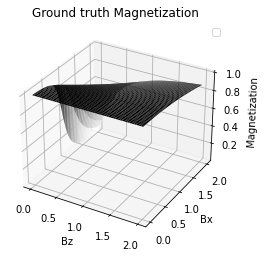

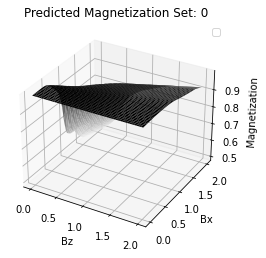

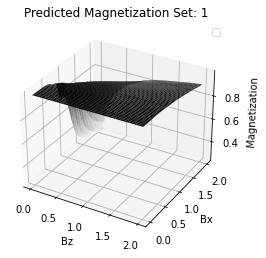

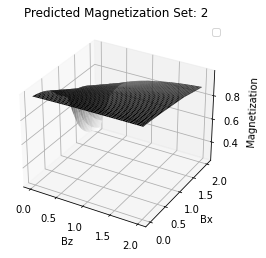

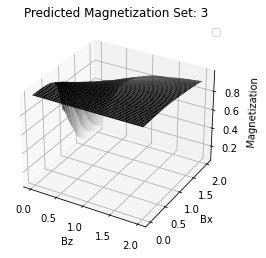

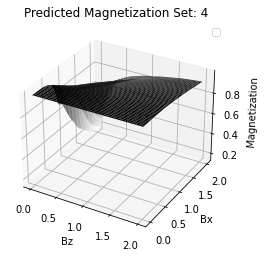

In [12]:
y = np.reshape(Bx, (50, 50))
x = np.reshape(Bz, (50, 50))
z = np.reshape(mag_6_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bz")
ax.set_ylabel("Bx")
ax.set_zlabel("Magnetization")

for i in range (stop):
    z = np.reshape(magnetization_6[i], (50, 50))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")

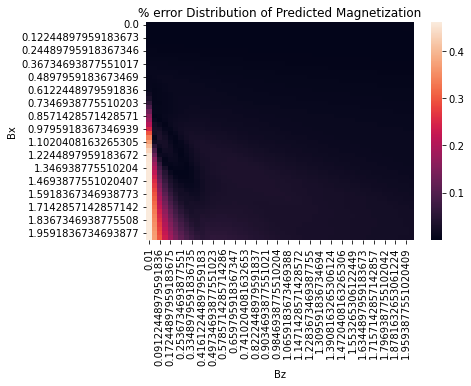

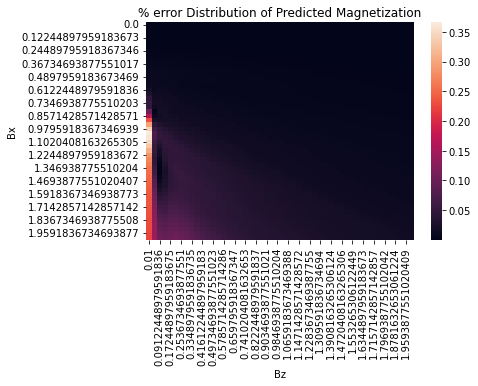

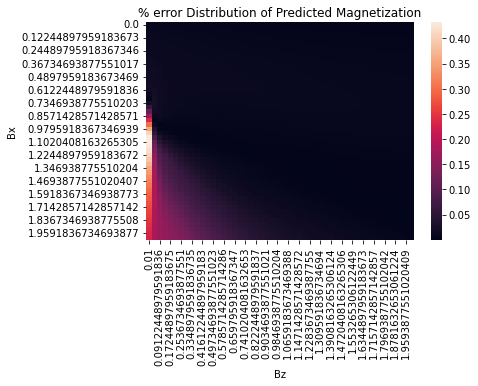

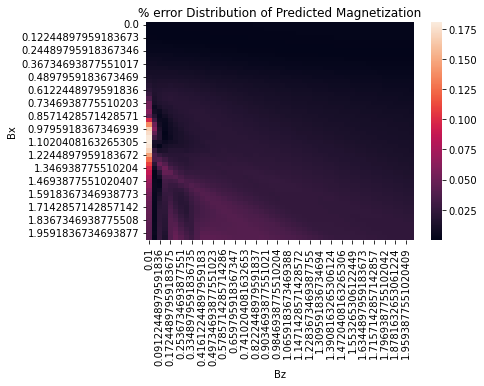

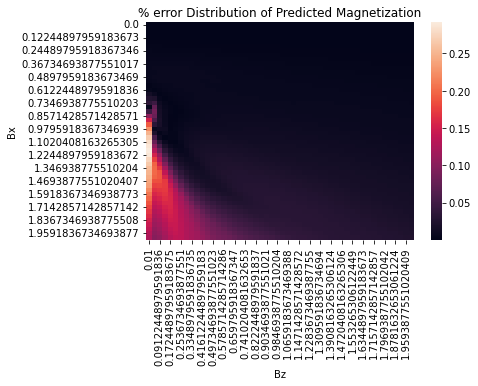

In [18]:
import pandas as pd
import seaborn as sns

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

for i in error_p:
    data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error':i})
    data = data.pivot(index='Bx', columns='Bz', values='% error')
#    plt.hist2d(Bx, By, bins=N_bins, cmap='plasma')
    sns.heatmap(data)

    # Plot a colorbar with label.
#    cb = plt.colorbar()

    # Add title and labels to plot.
    plt.title('% error Distribution of Predicted Wave Function (decimal value)')
#     plt.xlabel('Bx')
#     plt.ylabel('Bz')

    # Show the plot.
    plt.show()

In [33]:
training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 


split1 = int(len(pts)*0.9)
split2 = int(len(pts)/10)
split1 += len(pts)-(split1+split2)

training_data_2, val_data_2 = random_split(training_data_2, [split1,split2])
training_data_4, val_data_4 = random_split(training_data_4, [split1,split2])
training_data_7, val_data_7 = random_split(training_data_7, [split1,split2])

datasets = [training_data_2,
            training_data_4,
            training_data_7]

training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

val_data_6 = get_dataset(data_6, 6, pool_size)
val_data_8 = get_dataset(data_8, 8, pool_size)
val_data_9 = get_dataset(data_9, 9, pool_size)

val_datasets = [val_data_6, val_data_8, val_data_9, val_data_2, val_data_4, val_data_7]

val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))

mps_size = 5
model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss(reduction='sum')

warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

print("WARMUP TRAINING ITERATION: ")
for j in range(10):
    for i in range(3):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            loss_shape = np.shape(copy(loss).numpy())
            print(loss_shape)
            if (epoch % 10 == 0):
                current_loss = loss.item() *(2**warmup_data[i][1])
                print(warmup_data[i][1],"\t", current_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
print("__________________________________________________")
print()


WARMUP TRAINING ITERATION: 


TypeError: 'module' object is not callable

In [48]:
x = []
y= []
z= []
xyz = [x,y,z]
xyz[0].append(0)
print(xyz)

[[0], [], []]
